In [62]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO, autoguide, Predictive
from pyro.optim import Adam, ClippedAdam
import torch
import pyro

### Load data

In [63]:
df_weather = pd.read_csv('./data/2023_Weather.csv')
df_weather.drop(columns=['Unnamed: 0'], inplace=True)
df_weather.dropna(inplace=True)
df_weather.rename(columns={'Time': 'datetime'}, inplace=True)
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather.set_index('datetime', inplace=True)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8759 entries, 2023-01-01 00:00:00 to 2023-12-31 23:00:00
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   acc_precip         8759 non-null   float64
 1   mean_temp          8759 non-null   float64
 2   mean_relative_hum  8759 non-null   float64
 3   mean_wind_speed    8759 non-null   float64
 4   mean_radiation     8759 non-null   float64
dtypes: float64(5)
memory usage: 410.6 KB


In [64]:
# Read and parse
df_acc = pd.read_csv('./data/2022-2024-accident-data.csv', sep=';', dtype=str, encoding='latin1')
df_acc['X'] = df_acc['X_KOORDINAT'].str.replace(',', '.').astype(float)
df_acc['Y'] = df_acc['Y_KOORDINAT'].str.replace(',', '.').astype(float)
df_acc['datetime'] = pd.to_datetime(df_acc['UHELDSDATO'] + ' ' + df_acc['TIME'] + ':00', format='mixed') # %d.%m.%Y %H:%M

In [65]:
# Filter data
cols = ['X', 'Y', 'datetime']

df_acc = df_acc[cols]
df_acc = df_acc[(df_acc['datetime'] > '2023-01-01') & (df_acc['datetime'] < '2024-01-01')]
df_acc.sort_values(by='datetime', inplace=True)
df_acc.set_index('datetime', inplace=True)
df_acc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2071 entries, 2023-01-01 01:00:00 to 2023-12-31 20:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       2071 non-null   float64
 1   Y       2071 non-null   float64
dtypes: float64(2)
memory usage: 48.5 KB


In [66]:
df_acc

,X,Y
datetime,,
2023-01-01 01:00:00,722486.694,6174248.234
2023-01-01 06:00:00,723849.001,6179181.001
2023-01-01 15:00:00,724281.001,6180047.001
2023-01-02 07:00:00,725480.428,6175703.304
2023-01-02 07:00:00,725696.001,6172194.001
...,...,...
2023-12-31 11:00:00,725767.621,6175295.080
2023-12-31 14:00:00,721999.001,6174749.001
2023-12-31 14:00:00,727656.001,6174998.001


In [67]:
# Calculate grid
CELL_SIZE = 500

# Compute origin
minx, miny = df_acc['X'].min(), df_acc['Y'].min()

# Compute bin indices with floor
df_acc['ix'] = np.floor((df_acc['X'] - minx) // CELL_SIZE).astype(int)
df_acc['iy'] = np.floor((df_acc['Y'] - miny) // CELL_SIZE).astype(int)
    
# First, calculate the center coordinates for each cell
df_acc['center_x'] = minx + (df_acc['ix'] + 0.5) * CELL_SIZE
df_acc['center_y'] = miny + (df_acc['iy'] + 0.5) * CELL_SIZE

df_acc['cell_id'] = list(zip(df_acc['center_x'], 
                        df_acc['center_y']))

# Now groupby with the calculated centers
df_acc_centers = df_acc.groupby(['cell_id', 'datetime']).agg({
    'X': 'first',
    'Y': 'first'
})

df_acc_centers['acc_count'] = df_acc.groupby(['cell_id', 'datetime']).size()

In [68]:
unique_cells = df_acc_centers.index.get_level_values('cell_id').unique()
hours  = df_weather.index
idx = pd.MultiIndex.from_product([unique_cells, hours],
                                names=['cell_id', 'datetime'])

df_hourly = pd.DataFrame(index=idx)


In [69]:
# put the counts in and turn NaN → 0
df_hourly = df_hourly.join(df_acc_centers['acc_count']).fillna({'acc_count': 0}).astype({'acc_count': int})

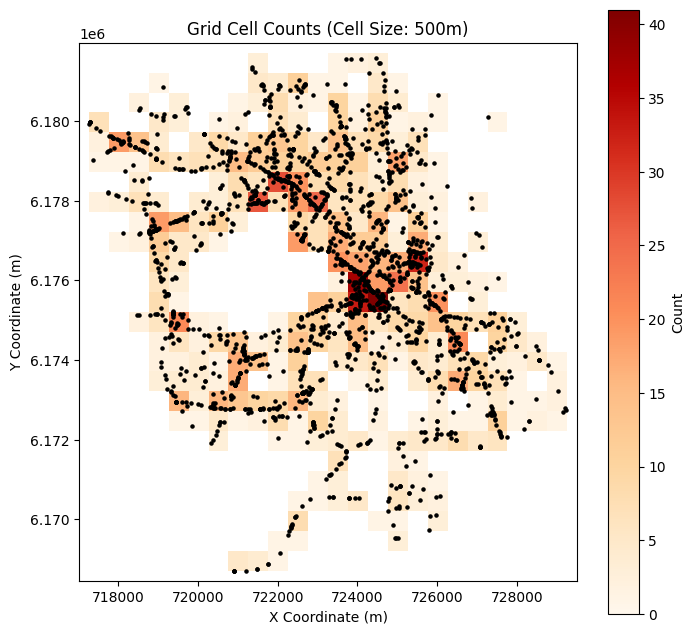

In [70]:
def plot_grid_counts(cell_centers, accidents=None):
    """
    Draws a coloured grid and overlays the accidents.
    :param cell_centers: series with the center coordinates of each cell as index, and with the accident counts per cell
    :param accidents: tuple with the coordinates of each accident
    """
    vmax = cell_centers.max()
    fig, ax = plt.subplots(figsize=(7,7))

    # draw each occupied cell
    for center_coords, count in cell_centers.items():
        # Extract center coordinates
        center_x, center_y = center_coords
        
        # Calculate top-left corner of the cell
        x0 = center_x - CELL_SIZE/2
        y0 = center_y - CELL_SIZE/2

        rect = plt.Rectangle(
            (x0, y0),
            CELL_SIZE, CELL_SIZE,
            facecolor=plt.cm.OrRd(count/vmax),
            edgecolor='grey', linewidth=0
        )
        ax.add_patch(rect)

    # Optional: scatter accident points if provided
    if accidents is not None:
        x = accidents[0]
        y = accidents[1]
        ax.scatter(x=x, y=y, s=5, c='black')    

    # Set plot properties
    ax.set_aspect('equal')
    plt.xlabel('X Coordinate (m)')
    plt.ylabel('Y Coordinate (m)')
    plt.title(f'Grid Cell Counts (Cell Size: {CELL_SIZE}m)')
    
    # Set reasonable axis limits based on the data
    all_x = [x for x, y in cell_centers.index]
    all_y = [y for x, y in cell_centers.index]
    x_min, x_max = min(all_x) - CELL_SIZE, max(all_x) + CELL_SIZE
    y_min, y_max = min(all_y) - CELL_SIZE, max(all_y) + CELL_SIZE
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    plt.tight_layout()
    plt.colorbar(plt.cm.ScalarMappable(cmap="OrRd", 
                                       norm=plt.Normalize(0, vmax)), 
                 ax=ax, label="Count")
    plt.show()

cell_centers = df_hourly[df_hourly['acc_count'] != 0].index.get_level_values('cell_id').value_counts()
accidents = (df_acc_centers['X'].tolist(), df_acc_centers['Y'].tolist())
plot_grid_counts(cell_centers, accidents)

In [71]:
df_hourly

acc_count
cell_id                   datetime                      
(717514.445, 6177963.565) 2023-01-01 00:00:00          0
                          2023-01-01 01:00:00          0
                          2023-01-01 02:00:00          0
                          2023-01-01 03:00:00          0
                          2023-01-01 04:00:00          0
...                                                  ...
(729014.445, 6173963.565) 2023-12-31 19:00:00          0
                          2023-12-31 20:00:00          0
                          2023-12-31 21:00:00          0
                          2023-12-31 22:00:00          0
                          2023-12-31 23:00:00          0

[2697772 rows x 1 columns]

In [72]:
df_daily = (
    df_hourly
    .groupby(
        [
          "cell_id", 
          pd.Grouper(level=df_hourly.index.names[1], freq="D")  
          # <─ here df.index.names[0] should be the datetime level’s name
        ]
    )["acc_count"]
    .sum()
    #.reset_index()
)
df = pd.DataFrame(df_daily)
df['day_of_year'] = df.index.get_level_values('datetime').dayofyear
df

acc_count  day_of_year
cell_id                   datetime                          
(717514.445, 6177963.565) 2023-01-01          0            1
                          2023-01-02          0            2
                          2023-01-03          0            3
                          2023-01-04          0            4
                          2023-01-05          0            5
...                                         ...          ...
(729014.445, 6173963.565) 2023-12-27          0          361
                          2023-12-28          0          362
                          2023-12-29          0          363
                          2023-12-30          0          364
                          2023-12-31          0          365

[112420 rows x 2 columns]

## Input and model

In [73]:
cell_map = {c: i for i, c in enumerate(unique_cells)} # map cells to integers from 0...len(unique_cells)-1

# Input tensors
cell_idx_tensor = torch.tensor(
    df.index.get_level_values("cell_id").map(cell_map).to_numpy(), dtype=torch.long
)
day_idx_tensor = torch.tensor(
    df.index.get_level_values("datetime").day_of_year.to_numpy(), dtype=torch.long
)
y_obs_tensor = torch.tensor(df["acc_count"].values, dtype=torch.long)

In [74]:
# models
def poisson_daily_model(cell_idx, day_idx, y=None):
    N = len(cell_idx)
    C = int(cell_idx.max()) + 1
    D = int(day_idx.max()) + 1

    sigma_u = pyro.sample("sigma_u", dist.HalfNormal(1.))
    alpha = pyro.sample("alpha", dist.Normal(-6, 0.5))

    with pyro.plate("cells", C):
        u = pyro.sample("u", dist.Normal(0., sigma_u))

    with pyro.plate("doy", D):
        beta_doy = pyro.sample("beta_doy", dist.Normal(0., 1.))

    with pyro.plate("data", N):
        n = alpha + u[cell_idx] + beta_doy[day_idx]
        lam = torch.exp(n)
        pyro.sample("obs", dist.Poisson(lam), obs=y)


### MCMC

In [75]:
# --- MCMC Inference ---
nuts_kernel = NUTS(poisson_daily_model)
mcmc = MCMC(nuts_kernel, num_samples=150, warmup_steps=50)
mcmc.run(cell_idx_tensor, day_idx_tensor, y=y_obs_tensor)

posterior_samples = mcmc.get_samples()
predictive = Predictive(
    poisson_daily_model,
    posterior_samples=posterior_samples,
    return_sites=["obs"]
)
mcmc_samples = predictive(cell_idx=cell_idx_tensor, day_idx=day_idx_tensor, y=None)["obs"]

Sample: 100%|██████████| 200/200 [00:37,  5.30it/s, step size=1.80e-01, acc. prob=0.925]


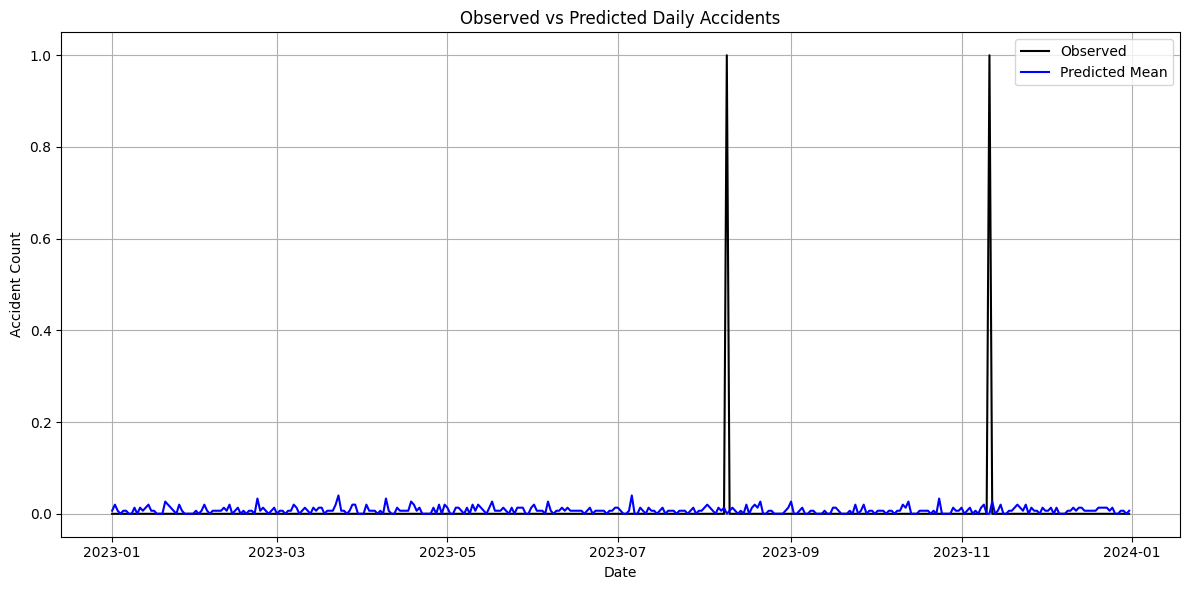

In [76]:
sample_cell_id = (717514.445, 6177963.565)  # pick one cell
mask = df.index.get_level_values("cell_id") == sample_cell_id

dates = df.index.get_level_values("datetime")[mask]
observed = y_obs_tensor[mask].numpy()
y_pred_samples_cell = mcmc_samples[:, mask].mean(0)  # shape: [num_samples, N_days_cell]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(dates, observed, label="Observed", color='black')
plt.plot(dates, y_pred_samples_cell, label="Predicted Mean", color='blue')
plt.title("Observed vs Predicted Daily Accidents")
plt.xlabel("Date")
plt.ylabel("Accident Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### SVI

In [77]:
# --- SVI Inference ---
guide = autoguide.AutoNormal(poisson_daily_model)
optim = Adam({"lr": 1e-2})
svi = SVI(poisson_daily_model, guide, optim, loss=Trace_ELBO())

for step in range(2000):
    loss = svi.step(cell_idx_tensor, day_idx_tensor, y_obs_tensor)
    if step % 200 == 0:
        print(f"[{step:4d}] loss = {loss:.1f}")

[   0] loss = 12909.6
[ 200] loss = 11047.8
[ 400] loss = 10624.7
[ 600] loss = 10524.8
[ 800] loss = 10543.5
[1000] loss = 10525.7
[1200] loss = 10539.4
[1400] loss = 10534.7
[1600] loss = 10528.2
[1800] loss = 10528.5


In [80]:
# SVI
svi_predictive = Predictive(
    poisson_daily_model,
    guide=guide,
    num_samples=1000,
    return_sites=["obs"]
)
svi_samples = svi_predictive(
    cell_idx=cell_idx_tensor,
    day_idx=day_idx_tensor,
    y=None
)["obs"]

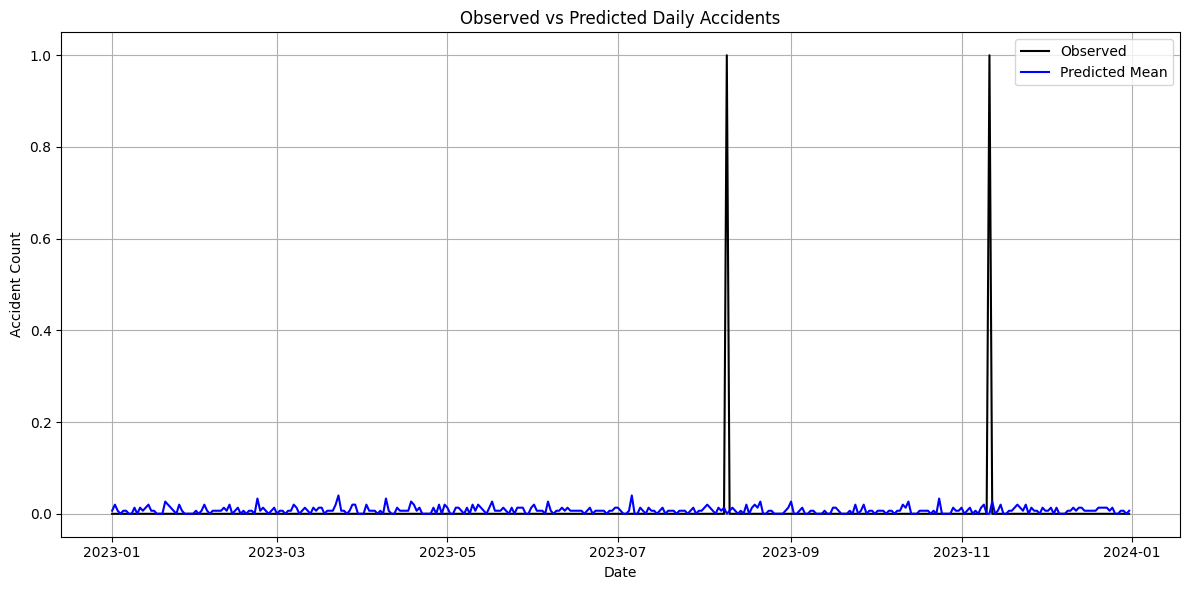

In [81]:
sample_cell_id = (717514.445, 6177963.565)  # pick one cell
mask = df.index.get_level_values("cell_id") == sample_cell_id

dates = df.index.get_level_values("datetime")[mask]
observed = y_obs_tensor[mask].numpy()
y_pred_samples_cell = mcmc_samples[:, mask].mean(0)  # shape: [num_samples, N_days_cell]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(dates, observed, label="Observed", color='black')
plt.plot(dates, y_pred_samples_cell, label="Predicted Mean", color='blue')
plt.title("Observed vs Predicted Daily Accidents")
plt.xlabel("Date")
plt.ylabel("Accident Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()